Here we'll be exploring a data set from the video game 'Player Unknown's Battlegrounds'.  In this game up to 100 people all drop onto an island and fight to the death until a single player remains.  We have a data set containing information such as how much damage a player did to opponents, how far a player traveled on the island, and how much a player healed himself.

The goal of this data set is to use it to determine what the player's chance of winning the match is based upon these stats.  If a player almost never moves and hides in a house, is he more likely to win than a player that travels extensively? Is a player who picks up a single weapon and sticks with it more likely to win than a player who frequently changes his weapon of choice?

Hopefully we can use this data set to better understand what the optimal strategy in the game is to improve our performance.  Let's learn more about the dataset.

In [1]:
import numpy as np
import pandas as pd  
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output

#Data is too large to be held in memory on my laptop, using dask to help with this
#import dask.dataframe as dd

#Useful for making pretty plots
import seaborn as sns

#Needed to normalize a uniform distribution (and vice versa)
from scipy.stats import norm

#For scaling our data and finding anomalies
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

#Keras is the backbone of our neural network algorithm
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

#Load data using dask
#TrainingSet = dd.read_csv('data/train.csv', engine='python')
#TestSet = dd.read_csv('data/test.csv', engine='python')
TrainingSet = pd.read_csv('data/train.csv')
TestSet = pd.read_csv('data/test.csv')
#TrainingSet.head()

Using TensorFlow backend.


In [2]:
#Grab general info about the dataframe
print(TrainingSet.info())
pd.set_option('display.max_columns', 26) #We'll always view all columns in dataframe now
TrainingSet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357336 entries, 0 to 4357335
Data columns (total 26 columns):
Id                 int64
groupId            int64
matchId            int64
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
maxPlace           int64
numGroups          int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(20)
memory usage: 864.3 MB
None


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,1050,2,1,65.320,29,28,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.550,26,23,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,1404,0,0,0.000,28,28,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,1069,0,0,0.000,97,94,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,1034,0,0,0.000,47,41,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217
5,5,2200824,5,0,2,128.10,0,0,0,25,1000,1,1,27.300,96,96,0,2221.0,0,0.0,0,0,1016.00,4,1500,0.9368
6,6,2568717,6,1,0,130.30,0,0,0,28,1037,1,1,5.954,44,40,0,721.7,0,0.0,0,0,280.10,3,1495,0.3721
7,7,2612473,7,1,1,661.80,2,3,2,3,1148,5,2,36.640,46,46,0,0.0,0,0.0,0,0,2617.00,4,1479,1.0000
8,8,2656377,8,0,3,94.72,0,0,5,50,1286,0,0,0.000,28,28,0,2963.0,0,28.9,0,0,3139.00,5,1528,0.7037
9,9,2700597,9,0,0,137.60,0,0,0,81,1000,0,0,0.000,25,23,0,0.0,0,0.0,0,0,238.70,3,1500,0.0417


We only have numerical columns!  This will simplify some of the analysis later.

Making the list of columns a bit easier to digest:

In [3]:
print("Training set, number of columns: " + str(len(TrainingSet.columns)))
print("Test set, number of columns    : " + str(len(TestSet.columns)))

#These are slow because you have to run through the whole dataset
#print("Training set, number of rows = " + str(len(TrainingSet)))
#print("Test set, number of rows =     " + str(len(TestSet)))
#For reference, the training set has 4357336 rows
#For reference, the test set has 1867913 rows

print("List of training set columns: " + str(TrainingSet.columns))

Training set, number of columns: 26
Test set, number of columns    : 25
List of training set columns: Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')


The test set has 1 less column than the training set, as expected.  We need to use the other variables to predict the 'winPlacePerc', a variable that ranges from 0 to 1, where 0 means the player is very unlikely to have won the game and 1 means the player almost certainly won the game.

Some variables seem unlikely to be as helpful for determining winPlacePerc. 'Id', 'groupId', and 'matchId' for example tell us nothing about the performance of the player.  We can drop these from our dataframes, which should help speed up our learning algorithm later.

In [4]:
#Dropping unnecessary columns.  Why we drop numGroups will be explained later
TrainingSet = TrainingSet.drop(['Id','groupId','matchId','numGroups'], axis=1)
TestSet = TestSet.drop(['Id','groupId','matchId','numGroups'], axis=1)
print("Training set, number of columns: " + str(len(TrainingSet.columns)))
print("Test set, number of columns    : " + str(len(TestSet.columns)))

Training set, number of columns: 22
Test set, number of columns    : 21


Let's check to see how many missing values (NaN) are present in our dataframe.

In [5]:
print(TrainingSet.isna().sum())
print(TestSet.isna().sum())

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64


Great, we also have a complete dataframe with no missing values!

Quickly double checking the sample submission document against our test set:

In [6]:
#SampleSub = pd.read_csv('data/sample_submission.csv', engine='python')
#print("Test set, number of rows =      " + str(len(TestSet)))
#print("SampleSub set, number of rows = " + str(len(SampleSub)))

So we'll have to take our test set, calculate the final column ('winPlacePerc') and transfer those values over to our sample submission document.

So now we may want to see what the distribution of 'winPlacePerc' in our dataframe looks like.  A normal distribution is ideal for most types of data analysis.

Training set skew: 0.10382623517588761


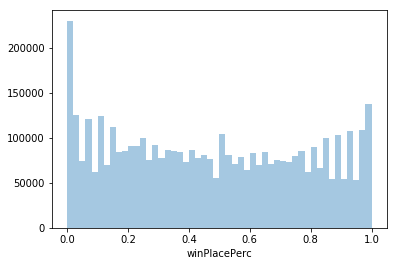

In [7]:
sns.distplot(TrainingSet['winPlacePerc'], kde=False)
print("Training set skew: " + str(TrainingSet['winPlacePerc'].skew()))

Our 'winPlacePerc' disribution is far from normal, and has a large spike near 0.  There also isn't much of a skew, but there also isn't much of a peak (at least as we'd expect in a normal distribution) either.

Let's see how the other variables look.  But first we can combine the training and test set into one to see the full distribution of possible values.

(6225249, 21)

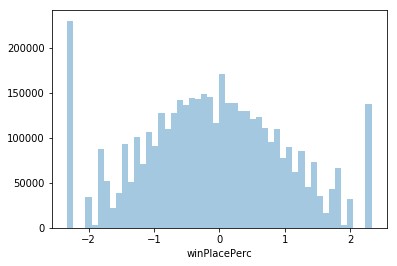

In [8]:
Y = TrainingSet[['winPlacePerc']].copy()

#In order to get more normal distribution, we need to remove the 0 and 1.0 values.  We'll bump them to 0.01 and 0.99.
#If our 'winPlacePerc' vaules are lower or higher than these values, respectively, we'll later bump them back to 0 and 1
mask = (Y['winPlacePerc'] == 0)
Y.loc[mask, 'winPlacePerc'] = 0.01
mask = (Y['winPlacePerc'] == 1)
Y.loc[mask, 'winPlacePerc'] = 0.99
#Now we won't have any infinity values when we apply ppx to our dataframe
Y['winPlacePerc'] = norm.ppf(Y['winPlacePerc'])

#Y = Y.apply(norm.ppf, axis=1)
sns.distplot(Y['winPlacePerc'], kde=False)
#new = old[['A', 'C', 'D']].copy()

n_TrainingSet = TrainingSet.shape[0] #Number of Training Set examples
n_TestSet = TestSet.shape[0] #Number of Test Set examples

AllData = pd.concat((TrainingSet, TestSet), sort=True).reset_index(drop=True) #Combine the two sets
AllData.drop(['winPlacePerc'], axis=1, inplace=True) #Drop the Y values
AllData.shape #New shape
#Y.head(50)

The data is at least slightly more normal in distribution now.

Let's see which variables are correlated with our winPlacePerc variable that we want to predict.

In [9]:
TrainingSetNumerics = TrainingSet.select_dtypes(include=[np.number])
NumericCorrelations = TrainingSetNumerics.corr()
print(NumericCorrelations['winPlacePerc'].sort_values(ascending = False),'\n')

winPlacePerc       1.000000
walkDistance       0.811857
boosts             0.618075
weaponsAcquired    0.571521
damageDealt        0.438552
heals              0.427986
kills              0.415350
longestKill        0.405800
killStreaks        0.372546
assists            0.304642
rideDistance       0.301220
DBNOs              0.279475
headshotKills      0.278705
revives            0.251399
winPoints          0.170407
swimDistance       0.154889
killPoints         0.090293
vehicleDestroys    0.057700
maxPlace           0.034235
roadKills          0.028879
teamKills         -0.006122
killPlace         -0.708314
Name: winPlacePerc, dtype: float64 



winPoints is the external ranking of the player based on past performance (higher value means more wins in the past).  It's curious that past successes don't translate well into winning the current match.
walkDistance is likely correlated with winning because you can only cover a large distance if you survive a long time. damageDealt and kills also correlate fairly well as you can only get high values in those categories if you do very well.

killPlace is your ranking (relative to the other players) of how many enemies you killed.  It makes sense that this is anti-correlated with winning; if you get no kills, you likely didn't survive very long (though this may not always be the case. Someone could hide in a building until the very end).

Let's see how correlated each variable is to one another.

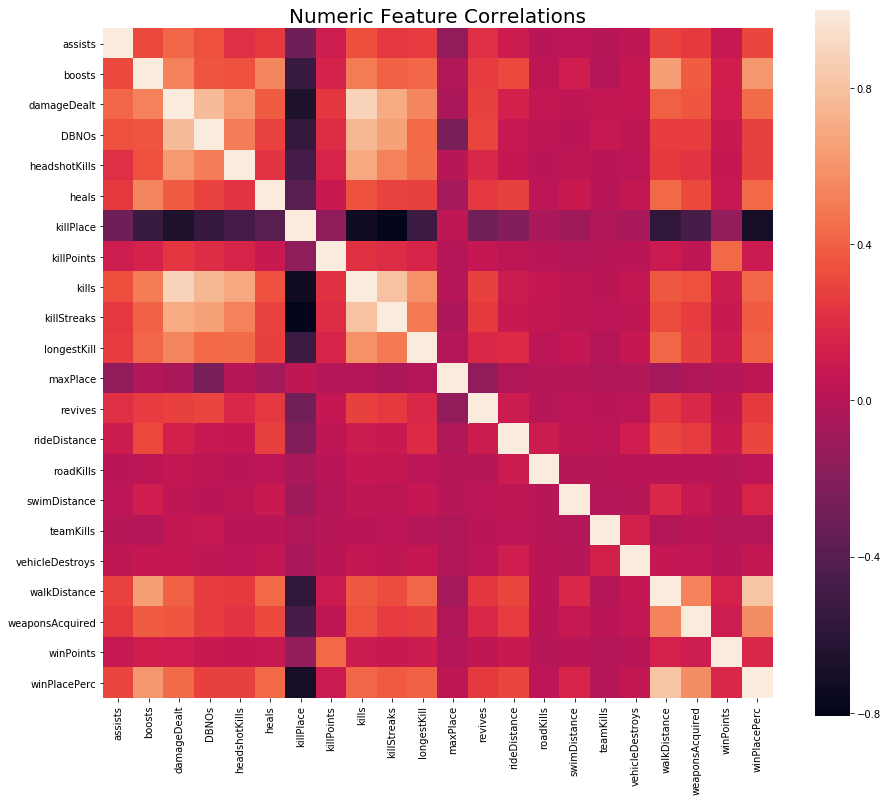

In [10]:
f , ax = plt.subplots(figsize = (15,13))
plt.title('Numeric Feature Correlations', y=1, size=20)
sns.heatmap(NumericCorrelations, square = True,  vmax=.82) #max is set to 0.82, since highest correlation value is 0.82

maxPlace and numGroups are highly correlated.  NumGroups is the 'Number of groups we have data for in the match' and maxPlace is 'Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.'  maxPlace is always greater than or equal to NumGroups in our data, so it would appear that some groups' data is missing from matches.  

Note also that winPlacePerc is based off of the maxPlace value rather than the numGroups value.  So if the game had 40 groups, but only recorded data for 38 of them, we'd have maxPlace = 40 and numGroups = 38.  And the group placed at 40th (last place) would have a winPlacePerc of 0, rather than the group that got 38th.  

For these reasons we dropped the numGroups variable earlier (along the Id variables).

This data is also likely to contain extreme outliers.  Players are often silly and not aiming to win.  Someone may drive a car for 30 straight minutes instead of trying to survive.  Another may hide in a building and take no actions because the pizza they ordered just arrived.  We should try to find and remove these anomalies from our training set to get better results.  But first we should scale our data to speed up our algorithm later.

In [11]:
#List of all columns
AllDataColumns = list(AllData.columns.values)

#Scale data
scaler = RobustScaler().fit(AllData)
AllData = scaler.transform(AllData)

#Transform back to dataframe
AllData = pd.DataFrame(AllData, columns=AllDataColumns)

#Double check that data is OK
print(AllData.shape)
AllData.head()

(6225249, 21)


,DBNOs,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,killStreaks,kills,longestKill,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,2.0,0.0,5.0,0.846366,0.0,4.0,-0.638298,0.165354,1.0,2.0,4.004905,-0.047619,1.0,591.3,0.0,0.0,0.0,0.0,0.124686,0.333333,-2.210526
1,1.0,1.0,0.0,-0.265836,1.0,0.0,-0.042553,0.338583,1.0,1.0,0.830779,-0.190476,0.0,0.0,0.0,0.0,0.0,0.0,-0.271110,0.000000,0.578947
2,1.0,0.0,1.0,0.031671,0.0,2.0,0.148936,2.952756,0.0,0.0,0.000000,-0.095238,1.0,0.0,0.0,0.0,0.0,0.0,1.597038,0.666667,4.368421
3,0.0,0.0,0.0,0.043077,0.0,0.0,0.829787,0.314961,0.0,0.0,0.000000,3.190476,0.0,0.0,0.0,0.0,0.0,0.0,-0.329697,-0.666667,-0.578947
4,0.0,0.0,1.0,-0.465570,0.0,1.0,0.234043,0.039370,0.0,0.0,0.000000,0.809524,0.0,0.0,0.0,0.0,0.0,0.0,0.040129,0.333333,-1.315789


Now we remove anomalies from our training set.

In [12]:
TrainingSet = AllData[:n_TrainingSet]
TestSet = TestSet = AllData[n_TrainingSet:]

#Our model will eat up too much memory on my poor laptop if we try to find anomalies on the entire training set at once
#So instead we will split the training set into several parts, then sum them together later
TrainingSet1,TrainingSet2,TrainingSet3,TrainingSet4,TrianingSet5,TrainingSet6,TrainingSet7,TrainingSet8 = np.vsplit(TrainingSet,8)
Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8 = np.split(Y,8)
YList = [Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8]
TrainingSetList = [TrainingSet1,TrainingSet2,TrainingSet3,TrainingSet4,TrianingSet5,TrainingSet6,TrainingSet7,TrainingSet8]
Y_NoAnomaliesList = [0,0,0,0,0,0,0,0]

#Find anomalies with IsolationForest.  We assume an anomaly rate of .15, which can be adjusted
clf = IsolationForest(max_samples = 256, n_estimators = 100, n_jobs = -1, contamination = 0.15)
for i in range(0,8):
    clf.fit(TrainingSetList[i])
    Y_NoAnomaliesList[i] = clf.predict(TrainingSetList[i]) #Predict whether each row is an outlier [1 = good, -1 = outlier]
    print("Checkpoint: Finished anomaly finding in TrainingSet subset #" + str(i+1))

#Remove anomalous rows from the training set
for i in range(0,8):
    Y_NoAnomaliesList[i] = pd.DataFrame(Y_NoAnomaliesList[i], columns = ['Top'])
    Y_NoAnomaliesList[i][Y_NoAnomaliesList[i]['Top'] == 1].index.values
    TrainingSetList[i] = TrainingSetList[i].iloc[Y_NoAnomaliesList[i][Y_NoAnomaliesList[i]['Top'] == 1].index.values]
    TrainingSetList[i].reset_index(drop = True, inplace = True)
    YList[i] = YList[i].iloc[Y_NoAnomaliesList[i][Y_NoAnomaliesList[i]['Top'] == 1].index.values]
    YList[i].reset_index(drop=True,inplace=True)

print("Checkpoint: Removed anomalous rows from TrainingSet")    

#Recombine into one dataframe
TrainingSet = pd.concat([TrainingSetList[0],TrainingSetList[1],TrainingSetList[2],TrainingSetList[3],TrainingSetList[4],TrainingSetList[5],TrainingSetList[6],TrainingSetList[7]])
Y_NoAnomalies = pd.concat([Y_NoAnomaliesList[0],Y_NoAnomaliesList[1],Y_NoAnomaliesList[2],Y_NoAnomaliesList[3],Y_NoAnomaliesList[4],Y_NoAnomaliesList[5],Y_NoAnomaliesList[6],Y_NoAnomaliesList[7]])
Y = pd.concat([YList[0],YList[1],YList[2],YList[3],YList[4],YList[5],YList[6],YList[7]])

#List number of anomalies found, as well as remaining non-anomalous rows
print("Number of Outliers:", Y_NoAnomalies[Y_NoAnomalies['Top'] == -1].shape[0])
print("Number of rows without outliers:", TrainingSet.shape[0])
print("Number of Y values:", Y.shape[0])

#Reset our training set size and our dataframe housing all data
n_TrainingSet = TrainingSet.shape[0]
AllData = pd.concat([TrainingSet, TestSet])

Checkpoint: Finished anomaly finding in TrainingSet subset #1
Checkpoint: Finished anomaly finding in TrainingSet subset #2
Checkpoint: Finished anomaly finding in TrainingSet subset #3
Checkpoint: Finished anomaly finding in TrainingSet subset #4
Checkpoint: Finished anomaly finding in TrainingSet subset #5
Checkpoint: Finished anomaly finding in TrainingSet subset #6
Checkpoint: Finished anomaly finding in TrainingSet subset #7
Checkpoint: Finished anomaly finding in TrainingSet subset #8
Checkpoint: Removed anomalous rows from TrainingSet
Number of Outliers: 653600
Number of rows without outliers: 3703736
Number of Y values: 3703736


Now we reacquire our training and test sets to use in our neural network algorithm.

In [13]:
print(AllData.shape)

TrainingSet = AllData[:n_TrainingSet]
TestSet = AllData[n_TrainingSet:]

print(TrainingSet.shape)
print(TestSet.shape)

(5571649, 21)
(3703736, 21)
(1867913, 21)


Here I borrow a function to plot the loss and val_loss as a function of epoch, live, as the neural network progresses. The code source is linked here: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [14]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.ylim(0, 1) 
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Now we create our deep neural network model. I separate the training set into a training set and a validation set to measure our progress as the neural network learns. To prevent overfitting I implement dropout on the neural network layers (regularization). Traditional relu activation functions are used.  The Adam optimizer generally is the best performing of the options available (combines the advantageous effects of RMSProp and gradient descent with momentum).

We will also utilize a callback to save and update the best found parameters after each epoch.  This way random deviations from the minimum as a result of using mini-batch (rather than just batch) gradient descent will not cause our final model output to be suboptimal.

In [15]:
X_tr, X_val, y_tr, y_val = train_test_split(TrainingSet, Y, test_size = 0.1)
model = Sequential()
BatchNormalization()
#Dropout instituted in the input layer; this is optional but may improve our final results
model.add(keras.layers.Dropout(0.2, input_shape=(len(TrainingSet.columns),))) #How to add dropout to input layer
model.add(Dense(1028,activation='relu')) #Input dimensions equal to # of columns in dataframe X
#model.add(Dense(1028, input_dim = len(TrainingSet.columns), activation='relu')) #Use this for no dropout on input
BatchNormalization()
Dropout(0.4) 
model.add(Dense(1028,activation='relu')) #Input dimensions automatically accounted for in later layers
BatchNormalization()
Dropout(0.4)
#model.add(Dense(1028,activation='relu')) #Optional additional hidden layer to deepen model
#BatchNormalization()
#Dropout(0.2)
model.add(Dense(100,activation='relu'))
BatchNormalization()
Dropout(0.2)
model.add(Dense(50))
BatchNormalization()
Dropout(0.1)
model.add(Dense(1))
keras.optimizers.Adam(lr=0.00001) #Adjust the learning rate, default value of 0.001 was too large
model.compile(optimizer='Adam',loss='mse',metrics=['accuracy']) #metrics = ['mean_squared_error']
#model.compile(optimizer='Adam',loss='mse') #removing/changing metric had no real effect

#Also we want to save the best parameters that we obtain during the training:
BestWeightsPath = './best_weights.hdf5'
SaveBestModel = keras.callbacks.ModelCheckpoint(BestWeightsPath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now we can attempt to use our model to fit the data.

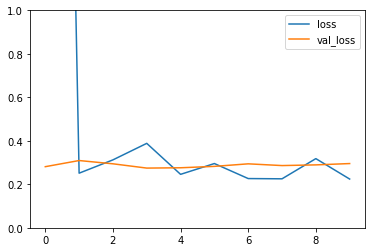


Epoch 00010: val_loss did not improve from 0.27461


In [16]:
model.fit(X_tr,y_tr,validation_data=(X_val,y_val), epochs=10, batch_size=256, verbose=1, callbacks=[plot_losses, SaveBestModel])

Finally we can use our model to fill out the predictions for our test set and write them onto the file 'PUBGSub'. We also remember to undo the logarithmic change to the Sale Price values we implemented earlier.

In [17]:
model.load_weights(BestWeightsPath)
np.sqrt(model.evaluate(X_val,y_val))
preds = model.predict(np.array(TestSet))
subm = pd.read_csv("data/sample_submission.csv")
subm.iloc[:,1] = np.array(model.predict(np.array(TestSet)))

#Undo the changes to Y we made earlier to make fitting better
print("Modifying Y output")
print("Undoing ppf transformation")
subm['winPlacePerc'] = norm.cdf(subm[['winPlacePerc']])
print("Rounding down low values")
mask = (subm['winPlacePerc'] <= 0.01)
subm.loc[mask, 'winPlacePerc'] = 0
print("Rounding up high values")
mask = (subm['winPlacePerc'] >= .99)
subm.loc[mask, 'winPlacePerc'] = 1.0

#subm['SalePrice'] = np.expm1(subm[['SalePrice']]) #undo the logarithm transformation we did on y earlier
print("Submitting to .csv file")
subm.to_csv('PUBGSub2.csv', index=None)

370374/370374 [==============================] - 32s 87us/step
Modifying Y output
Undoing ppf transformation
Rounding down low values
Rounding up high values
Submitting to .csv file


Now let's check to see if we get predictions that are similar to the flat distribution for 'winPlacePerc' that we observed in the TrainingSet.

0.4570643700716423


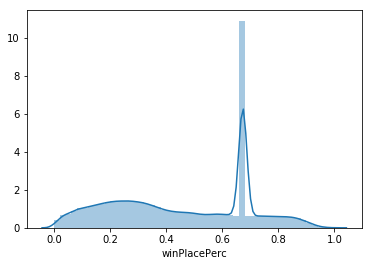

In [18]:
Results = pd.read_csv('PUBGSub2.csv')
sns.distplot(Results['winPlacePerc'], hist='norm')
print(Results['winPlacePerc'].median())
print(Results['winPlacePerc'].mean())